# Hidden Markov Model on Online Retail Data

This notebook demonstrates how to load, preprocess, and analyze an online retail dataset. We will compute probability distributions and conditional probability tables (CPTs) and then build a Hidden Markov Model (HMM) to model the data. Finally, we will evaluate and visualize the model’s performance.

In [1]:
# 📌 Install Dependencies (Only Required Once in Colab)
!pip install ucimlrepo hmmlearn > /dev/null 2>&1

In [2]:
# 📌 Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from hmmlearn import hmm
from sklearn.preprocessing import LabelEncoder, StandardScaler
from ucimlrepo import fetch_ucirepo

## Data Loading and Exploration

In this section, we load the online retail dataset from the UCI ML Repository and display some basic metadata and variable information.

In [17]:
# Fetch dataset
online_retail = fetch_ucirepo(id=352)

# Data (as pandas dataframes)
X = online_retail.data.features
y = online_retail.data.targets

# Metadata and variable information
print("Metadata:")
print(online_retail.metadata)

print("\nVariable Information:")
print(online_retail.variables)

Metadata:
{'uci_id': 352, 'name': 'Online Retail', 'repository_url': 'https://archive.ics.uci.edu/dataset/352/online+retail', 'data_url': 'https://archive.ics.uci.edu/static/public/352/data.csv', 'abstract': 'This is a transactional data set which contains all the transactions occurring between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online retail.', 'area': 'Business', 'tasks': ['Classification', 'Clustering'], 'characteristics': ['Multivariate', 'Sequential', 'Time-Series'], 'num_instances': 541909, 'num_features': 6, 'feature_types': ['Integer', 'Real'], 'demographics': [], 'target_col': None, 'index_col': ['InvoiceNo', 'StockCode'], 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2015, 'last_updated': 'Mon Oct 21 2024', 'dataset_doi': '10.24432/C5BW33', 'creators': ['Daqing Chen'], 'intro_paper': {'ID': 361, 'type': 'NATIVE', 'title': 'Data mining for the online retail industry: A case study of RFM model-based custome

## Create DataFrame and Check for Missing Values

We convert the features into a pandas DataFrame and quickly inspect the data along with any missing values.


In [18]:
# Create DataFrame from the features
data = pd.DataFrame(online_retail.data.features)

# Display the first few rows of data
display(data)

# Check for missing values
print("\nMissing values in each column:")
print(data.isna().any())

,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...
541904,PACK OF 20 SPACEBOY NAPKINS,12,12/9/2011 12:50,0.85,12680.0,France
541905,CHILDREN'S APRON DOLLY GIRL,6,12/9/2011 12:50,2.10,12680.0,France
541906,CHILDRENS CUTLERY DOLLY GIRL,4,12/9/2011 12:50,4.15,12680.0,France
541907,CHILDRENS CUTLERY CIRCUS PARADE,4,12/9/2011 12:50,4.15,12680.0,France



Missing values in each column:
Description     True
Quantity       False
InvoiceDate    False
UnitPrice      False
CustomerID      True
Country        False
dtype: bool


---
# 🔄 Data Preprocessing & Cleaning


1.   Remove any rows with missing descriptions and Customer IDs  
2.   Filter out transactions with negative quantity or price  
3.   Convert `InvoiceDate` to datetime format  
4.   Fill missing CustomerIDs with placeholder `-1`  
5.   Label econding 'Country'
----



In [19]:
# Drop rows with missing descriptions
data_clean = data.dropna(subset=['Description'])

# Remove negative Quantity and UnitPrice values (assume returns and errors)
data_clean = data_clean[(data_clean['Quantity'] > 0) & (data_clean['UnitPrice'] > 0)]

# Convert InvoiceDate to datetime
data_clean['InvoiceDate'] = pd.to_datetime(data_clean['InvoiceDate'])

# Fill missing CustomerID with a placeholder (-1) since it's categorical
data_clean['CustomerID'].fillna(-1, inplace=True)

data_clean.head()

<ipython-input-19-24f1d3d49d47>:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data_clean['CustomerID'].fillna(-1, inplace=True)


,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


----
# 📊 Feature Engineering & Probability Tables

We generate probability distributions for:  

*   Quantity per country  
*   Customer total purchasing behavior
*   Unit price per product description

##### These will help us construct the conditional probability tables (CPTs) for our developed HMM.
----

,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,CountryEncoded,TotalPurchase,LogTotalPurchase,PurchaseFrequency,TotalItemsBought
0,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,36,36,15.30,2.791165,297,1733
1,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,36,36,20.34,3.060583,297,1733
2,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,36,36,22.00,3.135494,297,1733
3,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,36,36,20.34,3.060583,297,1733
4,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,36,36,20.34,3.060583,297,1733


,Quantity,UnitPrice,CustomerID,Country,CountryEncoded,TotalPurchase,LogTotalPurchase,PurchaseFrequency,TotalItemsBought
Quantity,1.000000,-0.003773,0.025261,-0.016638,-0.016638,0.907338,0.108714,-0.027448,-0.021609
UnitPrice,-0.003773,1.000000,-0.038554,-0.003933,-0.003933,0.137404,0.104933,0.038251,0.038190
CustomerID,0.025261,-0.038554,1.000000,-0.056337,-0.056337,0.013354,0.175162,-0.975308,-0.972859
Country,-0.016638,-0.003933,-0.056337,1.000000,1.000000,-0.016271,-0.205118,0.139651,0.113515
CountryEncoded,-0.016638,-0.003933,-0.056337,1.000000,1.000000,-0.016271,-0.205118,0.139651,0.113515
TotalPurchase,0.907338,0.137404,0.013354,-0.016271,-0.016271,1.000000,0.142970,-0.014756,-0.009365
LogTotalPurchase,0.108714,0.104933,0.175162,-0.205118,-0.205118,0.142970,1.000000,-0.212659,-0.191252
PurchaseFrequency,-0.027448,0.038251,-0.975308,0.139651,0.139651,-0.014756,-0.212659,1.000000,0.996502
TotalItemsBought,-0.021609,0.038190,-0.972859,0.113515,0.113515,-0.009365,-0.191252,0.996502,1.000000


Column: Quantity


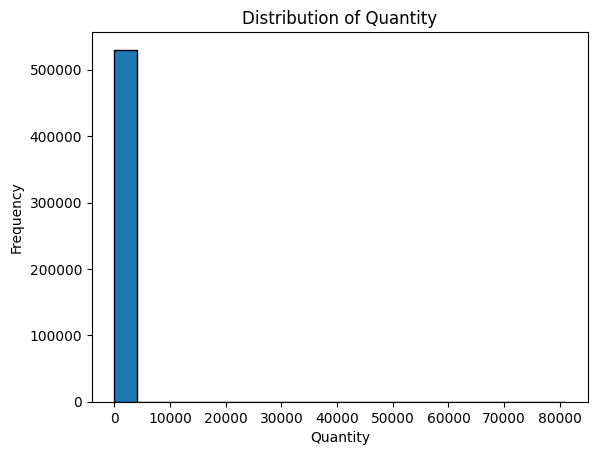

Column: UnitPrice


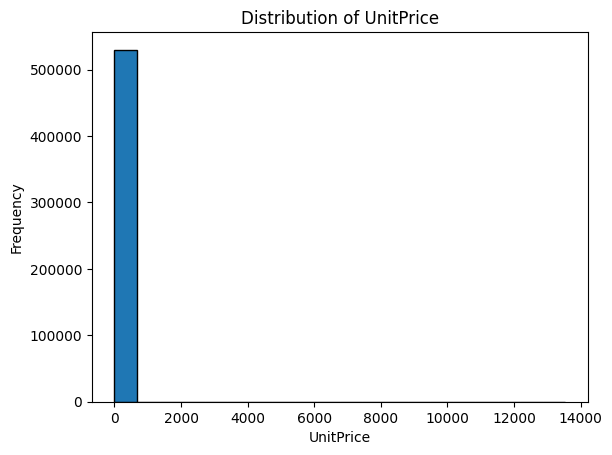

Column: CustomerID


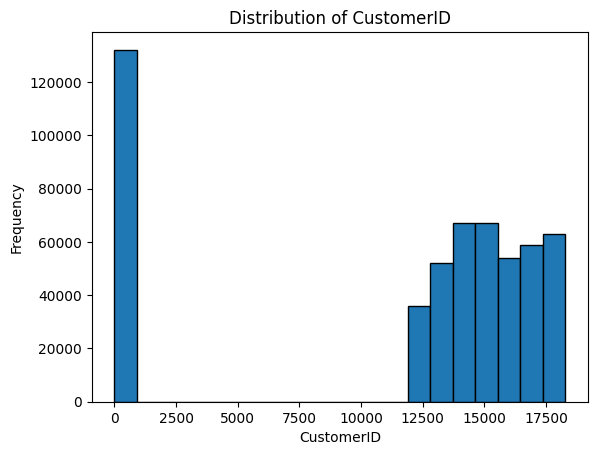

Column: Country


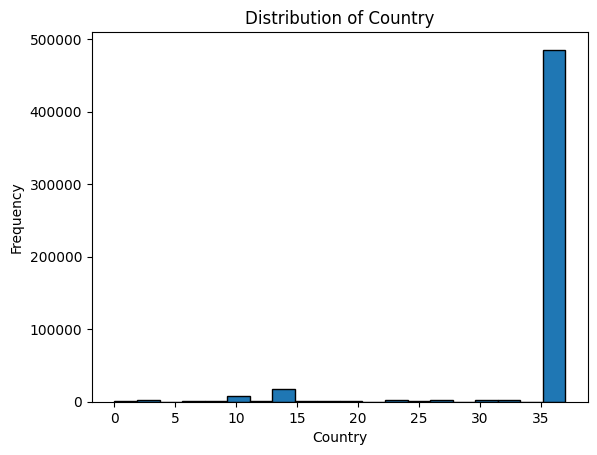

Column: CountryEncoded


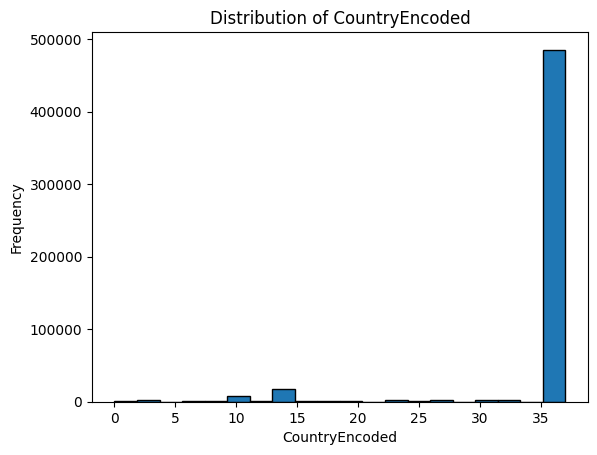

Column: TotalPurchase


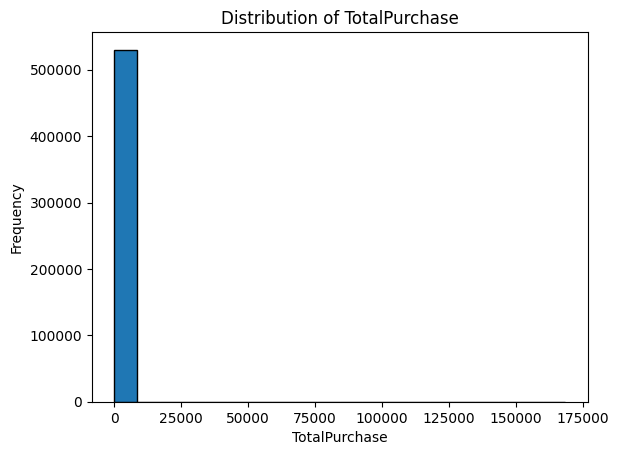

Column: LogTotalPurchase


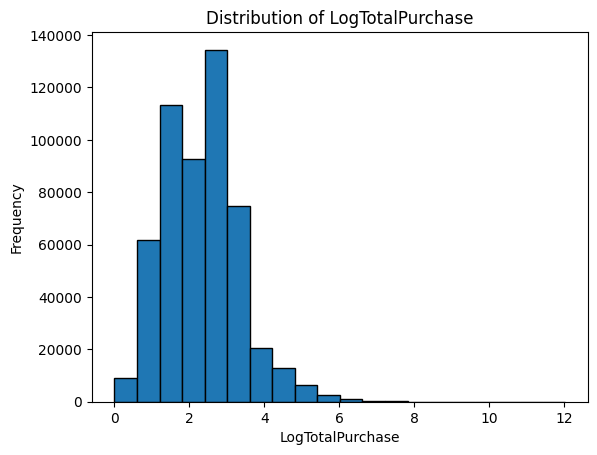

Column: PurchaseFrequency


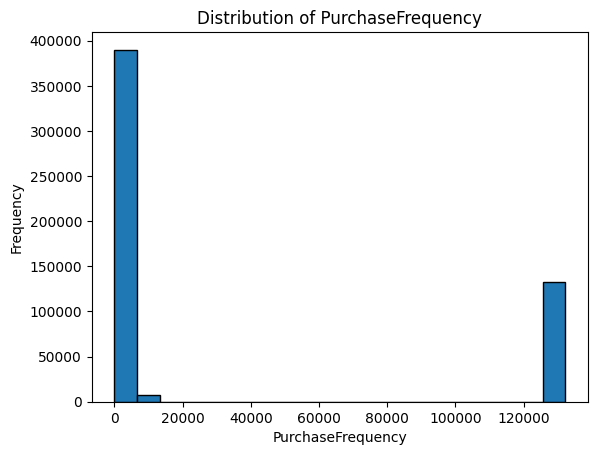

Column: TotalItemsBought


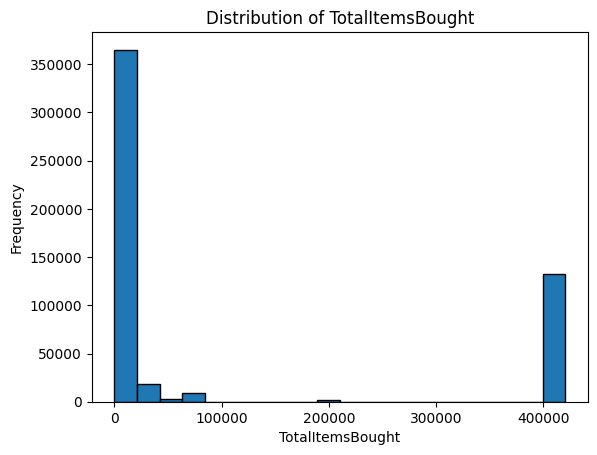

count    530104.000000
mean          3.907625
std          35.915681
min           0.001000
25%           1.250000
50%           2.080000
75%           4.130000
max       13541.330000
Name: UnitPrice, dtype: float64
count    530104.000000
mean         10.542037
std         155.524124
min           1.000000
25%           1.000000
50%           3.000000
75%          10.000000
max       80995.000000
Name: Quantity, dtype: float64
count    530104.000000
mean          2.331214
std           1.019145
min           0.001000
25%           1.558145
50%           2.388763
75%           2.928524
max          12.034517
Name: LogTotalPurchase, dtype: float64
count    530104.000000
mean      33475.756648
std       56936.084552
min           1.000000
25%         119.000000
50%         333.000000
75%        7847.000000
max      132220.000000
Name: PurchaseFrequency, dtype: float64
count    530104.000000
mean     109854.909450
std      179870.562803
min           1.000000
25%         886.000000
50%    

In [25]:
# Encode categorical variables
label_encoder_country = LabelEncoder()
data_clean['CountryEncoded'] = label_encoder_country.fit_transform(data_clean['Country'])

# Compute probability distributions
quantity_probs = data_clean['Quantity'].value_counts(normalize=True)
unitprice_probs = data_clean['UnitPrice'].value_counts(normalize=True)
country_probs = data_clean['Country'].value_counts(normalize=True)

# Compute Conditional Probability Tables (CPTs)

# CPT: Given a country, what is the probability of purchasing a certain quantity?
cpt_country_quantity = data_clean.groupby('Country')['Quantity'].value_counts(normalize=True).unstack(fill_value=0)

# CPT: Given a customer, what is the probability of total purchase?
data_clean['TotalPurchase'] = data_clean['Quantity'] * data_clean['UnitPrice']
cpt_customer_purchase = data_clean.groupby('CustomerID')['TotalPurchase'].sum()

# CPT: Given a product description, what is the probability of its unit price?
cpt_description_price = data_clean.groupby('Description')['UnitPrice'].value_counts(normalize=True).unstack(fill_value=0)

# Compute Total Purchase and Log Transformation
data_clean['TotalPurchase'] = data_clean['Quantity'] * data_clean['UnitPrice']
data_clean['LogTotalPurchase'] = np.log1p(data_clean['TotalPurchase'])  # log(1 + x) to handle zero values

# Compute total number of purchases per customer (Purchase Frequency)
customer_purchase_counts = data_clean.groupby('CustomerID')['InvoiceDate'].count().rename('PurchaseFrequency')

# Compute total items bought per customer
total_items_bought = data_clean.groupby('CustomerID')['Quantity'].sum().rename('TotalItemsBought')

# If the columns already exist, drop them before merging
data_clean = data_clean.drop(columns=['PurchaseFrequency', 'TotalItemsBought'], errors='ignore')

# Compute total number of purchases per customer (Purchase Frequency)
customer_purchase_counts = data_clean.groupby('CustomerID')['InvoiceDate'].count().rename('PurchaseFrequency')

# Compute total items bought per customer
total_items_bought = data_clean.groupby('CustomerID')['Quantity'].sum().rename('TotalItemsBought')

# Merge these features back into the original dataset
data_clean = data_clean.merge(customer_purchase_counts, on='CustomerID', how='left')
data_clean = data_clean.merge(total_items_bought, on='CustomerID', how='left')

# Fill any missing values (if needed)
data_clean.fillna(0, inplace=True)

# Display sample of the updated dataset
data_clean = data_clean.drop(columns=['PurchaseFrequency_dup', 'TotalItemsBought_dup'], errors='ignore')
display(data_clean.head())


numerical_data = data_clean.select_dtypes(include=['number'])
corr_matrix = numerical_data.corr()
display(corr_matrix)
for column in numerical_data.columns:
    print(f"Column: {column}")
    plt.hist(data_clean[column], bins=20, edgecolor='k')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.title(f'Distribution of {column}')
    plt.show()
for column in ['UnitPrice', 'Quantity', 'LogTotalPurchase', 'PurchaseFrequency', 'TotalItemsBought']:
    # print(f"Column: {column}")
    print(numerical_data[column].describe())


----
# 🤖 Defining the Customer Purchase Agent


Our AI agent is designed to:
* Predict **customer purchasing behavior** based on past transactions  
* Use **Hidden Markov Models (HMMs)** to identify patterns in purchases  
* Leverage **probabilistic reasoning** via Conditional Probability Tables (CPTs)  
* Recommend **marketing actions** based on predicted customer behavior  

Our agent
* **Preprocesses customer data** (e.g., scales purchases, encodes categorical features).  
* **Uses an HMM to predict** the most likely hidden state for a customer.  
* **Checks probability distributions** (CPTs) to refine predictions.  
* **Generates recommendations** (e.g., promotions, product suggestions).  



Below, we define the `CustomerPurchaseAgent` class. This agent takes the trained HMM model and CPTs to **analyze customer behavior and suggest actions**.

In [26]:
class CustomerPurchaseAgent:
    """
    AI Agent that predicts and influences customer purchases using Hidden Markov Models (HMM).

    The agent:
    * Predicts the most likely customer purchase behavior based on hidden states.
    * Uses probabilistic reasoning from Conditional Probability Tables (CPTs).
    * Generates personalized marketing recommendations.
    * Optimizes customer engagement and business efficiency.
    """

    def __init__(self, model, scaler, encoders, cpt_country_quantity, cpt_description_price):
        """
        Initializes the agent.

        Parameters:
        - model: Trained Hidden Markov Model (HMM).
        - scaler: StandardScaler used for normalizing input features.
        - encoders: Dictionary of LabelEncoders for categorical features (e.g., Country, Quarter).
        - cpt_country_quantity: CPT for probability of purchasing a quantity given a country.
        - cpt_description_price: CPT for probability of an item's unit price given its description.
        """
        self.model = model
        self.scaler = scaler
        self.encoders = encoders
        self.cpt_country_quantity = cpt_country_quantity
        self.cpt_description_price = cpt_description_price

    def preprocess_customer_data(self, customer_df):
        """
        Preprocesses customer transaction data before making predictions.
        - Applies log transformation to `TotalPurchase`
        - Normalizes numerical features using the stored scaler
        - Encodes categorical features
        """
        customer_df = customer_df.copy()  # Avoid SettingWithCopyWarning

        # Compute log-transformed purchase values
        customer_df['LogTotalPurchase'] = np.log1p(customer_df['Quantity'] * customer_df['UnitPrice'])

        # Encode Country
        customer_df['CountryEncoded'] = self.encoders['Country'].transform(customer_df['Country'])

        # Select the SAME features used in training
        features = ['LogTotalPurchase', 'CountryEncoded', 'PurchaseFrequency', 'TotalItemsBought']
        customer_features = customer_df[features].values

        # Normalize using stored scaler
        customer_features_scaled = self.scaler.transform(customer_features)
        return customer_features_scaled


    def predict_customer_behavior(self, customer_df):
        """
        Predicts the most likely hidden state (customer purchasing behavior).

        Parameters:
        - customer_df (DataFrame): Customer transaction data.

        Returns:
        - Predicted hidden states.
        """
        # Preprocess customer data
        customer_features_scaled = self.preprocess_customer_data(customer_df)

        # Predict the hidden state using the trained HMM
        predicted_states = self.model.predict(customer_features_scaled)

        return predicted_states



    def get_purchase_probability(self, country, quantity):
        """
        Computes the probability of purchasing a certain quantity given the customer's country.

        Parameters:
        - country (str): The customer's country.
        - quantity (int): The quantity of items purchased.

        Returns:
        - Probability value (float).
        """
        if country in self.cpt_country_quantity and quantity in self.cpt_country_quantity[country]:
            return self.cpt_country_quantity[country][quantity]
        return 0.0  # Default probability if no data is available

    def recommend_action(self, predicted_state, country=None, quantity=None):
      """
      Determines the best marketing action based on:
      - Predicted hidden state (customer behavior)
      - Past purchase history (if CPTs are available)

      Parameters:
      - predicted_state (int): The predicted hidden state from HMM.
      - country (str): The customer’s country (optional for now).
      - quantity (int): Number of items purchased (optional for now).

      Returns:
      - Suggested marketing action (str).
      """
      # Skip probability-based logic if CPTs are missing
      if self.cpt_country_quantity is None or self.cpt_description_price is None:
          if predicted_state in [0, 1]:
              return "Send Discount Offer"
          elif predicted_state in [2, 3]:
              return "Recommend Similar Products"
          else:
              return "Limited-Time Deal"

      # Use CPT-based logic (only when available)
      purchase_prob = self.get_purchase_probability(country, quantity) if country and quantity else 0.0

      if predicted_state in [0, 1]:  # Early-stage behavior
          return "Send Loyalty Discount Offer" if purchase_prob > 0.5 else "Recommend Low-Cost Popular Items"
      elif predicted_state in [2, 3]:  # Growth-phase purchasing trend
          return "Recommend Bundled Products" if purchase_prob > 0.3 else "Offer Free Shipping on Next Purchase"
      else:  # Late-stage, potential churn customer
          return "Send Exclusive Limited-Time Deal" if purchase_prob > 0.2 else "Retarget with Email Marketing Campaign"


    def analyze_customer(self, customer_df):
        """
        Predicts customer behavior and generates recommendations.

        Parameters:
        - customer_df (DataFrame): Customer transaction data.

        Returns:
        - List of recommendations for each customer.
        """
        predicted_states = self.predict_customer_behavior(customer_df)
        recommendations = []

        for i, state in enumerate(predicted_states):
            country = customer_df.iloc[i]['Country']
            quantity = customer_df.iloc[i]['Quantity']
            recommendation = self.recommend_action(state, country, quantity)
            recommendations.append((customer_df.iloc[i]['CustomerID'], state, recommendation))

        return recommendations


-----
# ⚡ Optimizing HMM Training
##  Performance Improvements:
- **Reduce Hidden States:** Aggregate transactions by **Month** instead of **Quarter**  
- **Normalize Purchases:** Use `log(1 + TotalPurchase)` to stabilize the variance  
- **Faster Computation:** Use `"diag"` covariance instead of `"full"`  
- **Downsampling:** Train on a sample of **500 transactions per month**  


## Feature Engineering: Quarter Calculation and Encoding

We derive a new feature 'PeriodEncoded' from the `InvoiceDate` and then encode it as numerical hidden states for our HMM. Aggregating transactions by **Month** means we can look at a larger number of hidden states, which is better for our model.

----

## Training the Hidden Markov Model (HMM)
1. Define hidden states (aggregated by month)  
2. Encode categorical time periods  
3. Scale `TotalPurchase` observations  
4. Train a **GaussianHMM** model with optimized settings  
5. Predict hidden states and evaluate accuracy  


In [32]:
from hmmlearn import hmm


# Function to help sampling
def sampling_group(group, sample_size):
    return group.sample(n=min(sample_size, len(group)), random_state=42)

# Clean up DF by Invoice Date to create hidden states by month
data_clean['InvoiceDate'] = pd.to_datetime(data_clean['InvoiceDate'])
data_clean['YearMonth'] = data_clean['InvoiceDate'].dt.to_period('M')  # Aggregate transactions by months to increase number of hidden states

# Encoding the time period (months) for HMM
label_encoder_time = LabelEncoder()
data_clean['PeriodEncoded'] = label_encoder_time.fit_transform(data_clean['YearMonth'])

# Generate random sample of 20K rows to train model stratified by month
sampled_data = data_clean.groupby('YearMonth').apply(sampling_group, sample_size = (100000 // len(data_clean['YearMonth'].unique()))).reset_index(drop=True)

# Compute Log-Transformed Purchase Amount
sampled_data['TotalPurchase'] = sampled_data['Quantity'] * sampled_data['UnitPrice']
sampled_data['LogTotalPurchase'] = np.log1p(sampled_data['TotalPurchase'])  # log(1 + x) to handle zero values

# Apply log transformation to cleaned data DF to stabilize variance
data_clean['LogTotalPurchase'] = np.log1p(data_clean['Quantity'] * data_clean['UnitPrice'])

# Define Features for HMM and generated states based on features
features = ['LogTotalPurchase', 'CountryEncoded', 'PurchaseFrequency', 'TotalItemsBought']

# Check if any selected feature is missing
missing_features = [col for col in features if col not in sampled_data.columns]
if missing_features:
    raise ValueError(f"Missing features in sampled_data: {missing_features}")

observations = sampled_data[features].values
hidden_states = sampled_data['PeriodEncoded'].values         # Encoded month

# Standardizing the observations (important for Gaussian HMM)
scaler = StandardScaler()
observations_scaled = scaler.fit_transform(observations)

# Define the HMM Model by using one hidden state per time period (month)
n_hidden_states = len(label_encoder_time.classes_)
model = hmm.GaussianHMM(n_components=n_hidden_states, covariance_type="full", n_iter=1000, random_state=42)

# Train the HMM using scaled observations
model.fit(observations_scaled)

# Confirm number of features learned by HMM
if model.means_.shape[1] != len(features):
    raise ValueError(f"Model trained on {model.means_.shape[1]} features, expected {len(features)}!")

# Create predict hidden states based on observations
predicted_states = model.predict(observations_scaled)

# Get model parameters: ransition & emission Matrices
print("🔄 Transition Matrix:")
print(model.transmat_)
print("\n📊 Emission Matrix (State Means):")
print(model.means_)

<ipython-input-32-ff575c7f5031>:17: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sampled_data = data_clean.groupby('YearMonth').apply(sampling_group, sample_size = (100000 // len(data_clean['YearMonth'].unique()))).reset_index(drop=True)


🔄 Transition Matrix:
[[4.45027150e-08 5.26251837e-01 5.91303719e-03 1.76059182e-12
  3.05343687e-02 4.77880363e-03 1.71984128e-04 2.13677962e-12
  7.10280079e-18 1.97821624e-04 3.49968542e-09 4.42705350e-04
  4.31709394e-01]
 [1.70212048e-02 2.70254430e-01 3.03995967e-03 4.75777066e-14
  1.41267694e-02 6.99942515e-02 6.54210558e-04 1.37137601e-02
  5.47277315e-02 4.68120118e-01 6.85982008e-25 2.43155576e-02
  6.40320065e-02]
 [2.15475657e-02 2.29597597e-01 1.10590314e-02 1.15402848e-01
  1.46738251e-02 3.88890427e-02 3.09892973e-06 3.26311647e-02
  6.56200841e-02 3.91042762e-01 9.94358143e-16 1.92395628e-10
  7.95329804e-02]
 [5.20424419e-02 9.19570033e-02 7.81554553e-04 6.84022451e-02
  2.07850161e-02 1.77395568e-01 5.79688340e-03 3.88516952e-02
  8.79754323e-02 4.35784522e-01 1.42695282e-09 2.02276363e-02
  2.59402293e-23]
 [3.80371512e-02 6.52947487e-03 6.12449489e-03 3.90833725e-01
  1.89189186e-02 1.38223460e-01 2.36038093e-01 2.45961029e-02
  5.81152986e-02 1.15289688e-12 2.14282

----
# Model Evaluation & Results

We assess the performance of our HMM model by:
- comparing predicted hidden states vs. actual periods  
- visualizing state transitions over time  
- computing **Log-Likelihood** and the model's **Accuracy**  
----

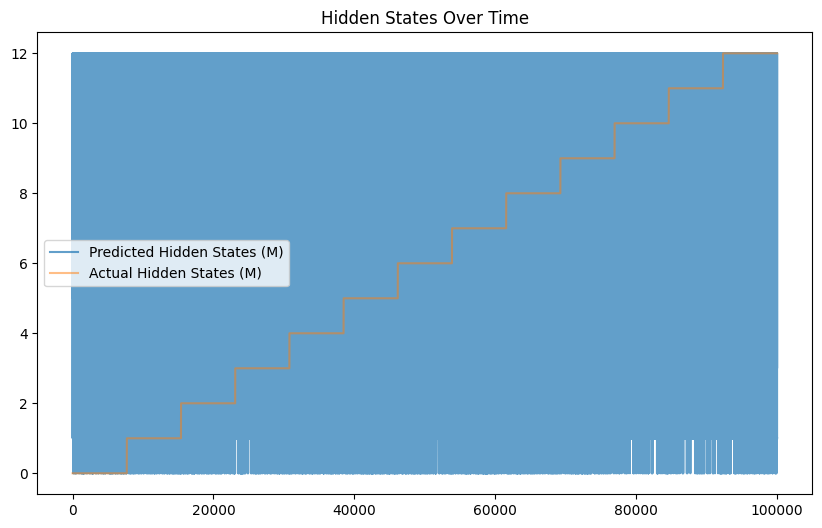

,CustomerID,InvoiceDate,TotalPurchase,PeriodEncoded,LogTotalPurchase,CountryEncoded,PurchaseFrequency,TotalItemsBought
0,17850.0,2010-12-01 08:26:00,15.30,0,2.791165,36,297,1733
1,17850.0,2010-12-01 08:26:00,20.34,0,3.060583,36,297,1733
2,17850.0,2010-12-01 08:26:00,22.00,0,3.135494,36,297,1733
3,17850.0,2010-12-01 08:26:00,20.34,0,3.060583,36,297,1733
4,17850.0,2010-12-01 08:26:00,20.34,0,3.060583,36,297,1733
...,...,...,...,...,...,...,...,...
530099,12680.0,2011-12-09 12:50:00,10.20,12,2.415914,13,52,443
530100,12680.0,2011-12-09 12:50:00,12.60,12,2.610070,13,52,443
530101,12680.0,2011-12-09 12:50:00,16.60,12,2.867899,13,52,443
530102,12680.0,2011-12-09 12:50:00,16.60,12,2.867899,13,52,443



📈 Log-Likelihood: -759165650105813632.0000
✅ Prediction Accuracy: 0.0871


In [33]:
# Optionally: Visualize the results (for example, how hidden states vary over time)
plt.figure(figsize=(10, 6))
plt.plot(predicted_states, label="Predicted Hidden States (M)", alpha=0.7)
plt.plot(hidden_states, label="Actual Hidden States (M)", alpha=0.5)
plt.legend()
plt.title("Hidden States Over Time")
plt.show()

# Step 6: Analyze customer behavior over time
sampled_data['PeriodEncoded'] = label_encoder_time.inverse_transform(predicted_states)

# Inspect the results
display(data_clean[['CustomerID', 'InvoiceDate', 'TotalPurchase', 'PeriodEncoded', 'LogTotalPurchase', 'CountryEncoded', 'PurchaseFrequency', 'TotalItemsBought']])

# Evaluate model performance
log_likelihood = model.score(observations)
print(f"\n📈 Log-Likelihood: {log_likelihood:.4f}")
accuracy = np.sum(predicted_states == hidden_states) / len(hidden_states)
print(f"✅ Prediction Accuracy: {accuracy:.4f}")

----
# 🎯 Using the AI Agent for Predictions

## How Do We Use Our AI Agent?
Now that our **Hidden Markov Model (HMM) is trained**, we can use the `CustomerPurchaseAgent` to:  
* Predict **which hidden state a customer belongs to**  
* Determine **the probability of a purchase based on past behaviors**  
* **Recommend personalized marketing actions** based on predicted trends  

## Making Predictions for Future Purhcases
1. We take a sample of **recent customer transactions**.  
2. We preprocess and **normalize** the data.  
3. We **pass the data into the AI agent**, which predicts a hidden state for each customer.  
4. The agent **suggests an action** (e.g., discount, cross-sell, limited-time deal).  



In [31]:
# Encode categorical variables
encoders = {
    'Country': label_encoder_country
}

# Create the agent with updated features
customer_agent = CustomerPurchaseAgent(
    model=model,
    scaler=scaler,
    encoders=encoders,  # Now needed for Country encoding
    cpt_country_quantity=None,  # Not needed for this test
    cpt_description_price=None  # Not needed for this test
)

# Define Observations Used for Prediction
print("Observations used in HMM Model for Prediction:")
print("- LogTotalPurchase (log-transformed total purchase amount)")
print("- CountryEncoded (numerical encoding of customer country)")
print("- PurchaseFrequency (number of purchases made by the customer)")
print("- TotalItemsBought (total quantity of items bought by the customer)")

# Select 20 random customer transactions for prediction
sample_customer_data = sampled_data.sample(n=20, random_state=123).reset_index(drop=True)

# Preprocess sample customer data before making predictions
sample_customer_features = customer_agent.preprocess_customer_data(sample_customer_data)

# Display Sample Data Before Prediction
print("\n🔍 Sample Transactions Used for Prediction:")
display(sample_customer_data[['CustomerID', 'TotalPurchase', 'LogTotalPurchase', 'Country', 'PurchaseFrequency', 'TotalItemsBought']])

# Analyze customer behavior and generate marketing recommendations
customer_recommendations = customer_agent.analyze_customer(sample_customer_data)

# Display Predictions and Recommendations
print("\n📌 AI Agent Predictions and Suggested Actions:")
for customer_id, state, recommendation in customer_recommendations:
    print(f"Customer {customer_id} → Predicted State: {state}, Recommended Action: {recommendation}")


Observations used in HMM Model for Prediction:
- LogTotalPurchase (log-transformed total purchase amount)
- CountryEncoded (numerical encoding of customer country)
- PurchaseFrequency (number of purchases made by the customer)
- TotalItemsBought (total quantity of items bought by the customer)

🔍 Sample Transactions Used for Prediction:


,CustomerID,TotalPurchase,LogTotalPurchase,Country,PurchaseFrequency,TotalItemsBought
0,17567.0,11.40,2.517696,36,165,2632
1,-1.0,371.70,5.920774,36,132220,420564
2,18069.0,1.30,0.832909,36,470,1311
3,17338.0,3.75,1.558145,36,753,3128
4,16474.0,2.89,1.358409,36,360,943
5,15104.0,16.95,2.887590,36,69,637
6,-1.0,4.96,1.785070,36,132220,420564
7,14178.0,3.40,1.481605,36,327,1505
8,-1.0,5.79,1.915451,36,132220,420564
9,-1.0,5.91,1.932970,36,132220,420564



📌 AI Agent Predictions and Suggested Actions:
Customer 17567.0 → Predicted State: 4, Recommended Action: Limited-Time Deal
Customer -1.0 → Predicted State: 7, Recommended Action: Limited-Time Deal
Customer 18069.0 → Predicted State: 4, Recommended Action: Limited-Time Deal
Customer 17338.0 → Predicted State: 2, Recommended Action: Recommend Similar Products
Customer 16474.0 → Predicted State: 2, Recommended Action: Recommend Similar Products
Customer 15104.0 → Predicted State: 2, Recommended Action: Recommend Similar Products
Customer -1.0 → Predicted State: 7, Recommended Action: Limited-Time Deal
Customer 14178.0 → Predicted State: 4, Recommended Action: Limited-Time Deal
Customer -1.0 → Predicted State: 7, Recommended Action: Limited-Time Deal
Customer -1.0 → Predicted State: 7, Recommended Action: Limited-Time Deal
Customer 15159.0 → Predicted State: 0, Recommended Action: Send Discount Offer
Customer 13178.0 → Predicted State: 2, Recommended Action: Recommend Similar Products
Cus